## Tutorial for using SMOPCA on Spatial-CITE-seq Human Tonsil dataset
Import modules.

In [4]:
import logging
import h5py
import numpy as np
import pandas as pd
import scanpy as sc
import warnings
from SMOPCA.model import SMOPCA
from sklearn.cluster import KMeans

for handler in logging.root.handlers[:]:  # avoid DEBUG level information in jupyter notebook
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO)  # use DEBUG for verbose information
warnings.filterwarnings('ignore')


Load and check dataset.

In [5]:
data_file = h5py.File("/nfs/public/chenmo/PCA/SMOPCA-v2/data/RealData/SpatialCITEseq/Humantonsil_filtered.h5", 'r')
X1 = np.array(data_file['normalized_svg_count'])
X2 = np.array(data_file['normalized_protein_count'])
pos = np.array(data_file['pos'])
data_file.close()
print(X1.shape, X2.shape, pos.shape)

(2491, 959) (2491, 283) (2491, 2)


Build the SMOPCA model and inference parameters.

In [6]:
smopca = SMOPCA(Y_list=[X1.T, X2.T], Z_dim=20, pos=pos, intercept=False, omics_weight=False)
smopca.estimateParams(sigma_init_list=(1, 1), tol_sigma=2e-5, sigma_xtol_list=(1e-6, 1e-6), gamma_init=1, estimate_gamma=True)
z = smopca.calculatePosterior()
y_pred = KMeans(n_clusters=7, n_init=100).fit_predict(z)

INFO:SMOPCA.model:SMOPCA object created, with 2491 cells and [959, 283] features and matern kernel
INFO:SMOPCA.model:start estimating parameters, this will take a while...
INFO:SMOPCA.model:calculating matern kernel, nu = 1.5, length_scale = 1
INFO:SMOPCA.model:estimating sigma1
INFO:SMOPCA.model:sigma1 using bound: (0.90000, 1.00000)
INFO:SMOPCA.model:iter 0 sigma1 brentq done, sigma1sqr = 1.00000, sigma1hatsqr = 0.95174
INFO:SMOPCA.model:iter 1 sigma1 brentq done, sigma1sqr = 0.95174, sigma1hatsqr = 0.95171
INFO:SMOPCA.model:iter 2 sigma1 brentq done, sigma1sqr = 0.95171, sigma1hatsqr = 0.95171
INFO:SMOPCA.model:reach tolerance threshold, sigma1 done!
INFO:SMOPCA.model:estimating sigma2
INFO:SMOPCA.model:sigma2 using bound: (0.70000, 0.80000)
INFO:SMOPCA.model:iter 0 sigma2 brentq done, sigma2sqr = 1.00000, sigma2hatsqr = 0.78589
INFO:SMOPCA.model:iter 1 sigma2 brentq done, sigma2sqr = 0.78589, sigma2hatsqr = 0.78569
INFO:SMOPCA.model:iter 2 sigma2 brentq done, sigma2sqr = 0.78569, s

Visualize the inferred spatial domain.

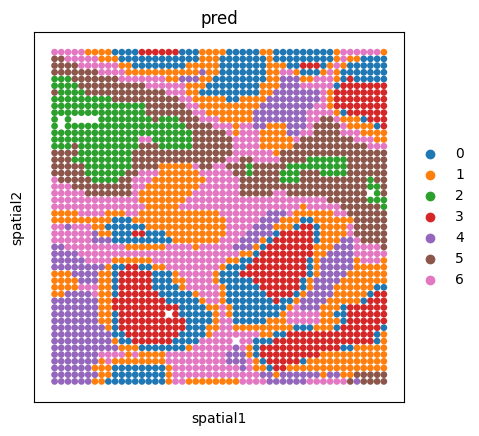

In [7]:
adata_res = sc.AnnData(z)
adata_res.obsm['spatial'] = pos
adata_res.obs['pred'] = pd.Categorical(y_pred)
sc.pl.spatial(adata_res, color='pred', spot_size=1)

Visualize the latent space using UMAP.

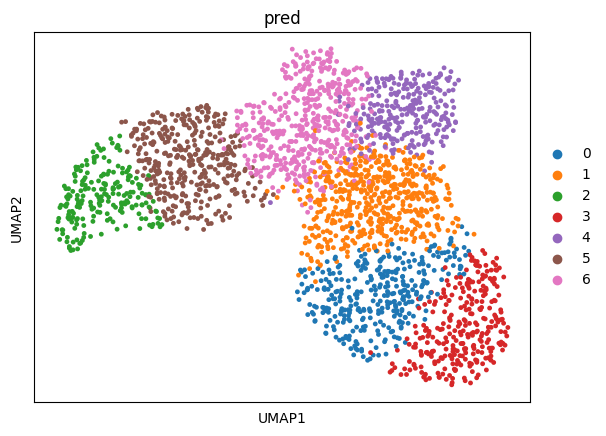

In [13]:
sc.pp.neighbors(adata_res, n_neighbors=100, use_rep='X', metric='euclidean')
sc.pl.umap(adata_res, color='pred')
sc.tl.umap(adata_res, min_dist=1)

## Perform DIfferential Expression Analysis with SMOPCA Predicted labels
Find marker gene for each cluster using FindMarkers.

In [ ]:
library(rhdf5)
library(dplyr)
library(Seurat)
library(Matrix)
library(patchwork)
library(pheatmap)
h5_file <- H5Fopen("./data/Humantonsil_filtered.h5")
X <- as(h5_file$raw_gene_count, "sparseMatrix")
cell <- as.matrix(h5_file$cell)  
gene <- as.matrix(h5_file$gene)
h5closeAll()
rownames(X) <- gene
colnames(X) <- cell
y_pred <- as.matrix(read.csv("./data/smopca_pred_label.csv", row.names=1))

seu <- CreateSeuratObject(counts = X, project = "diff_expr", min.cells = 0, min.features = 0)
seu <- NormalizeData(seu, normalization.method = "LogNormalize", scale.factor = 10000)
Idents(seu) <- y_pred

y_unique <- c('0', '1', '2', '3', '4', '5', '6')
for (g in y_unique) {
    de.markers <- FindMarkers(seu, ident.1 = g, ident.2 = NULL, only.pos = F)
    write.csv(de.markers, file=paste0("./res/cluster_", g, "_marker.csv"))
    rm(de.markers)
}

Select marker genes and perpare expression data for visualization.

In [3]:
import h5py
import numpy as np
import pandas as pd

top_gene_num = 10  # top gene num of each cluster
cluster_list = [0, 1, 2, 3, 4, 5, 6]
de_csv_list = []
cluster_gene_dict = {}
top_gene_list = []
all_top_gene_list = []

y_pred = pd.read_csv("./data/smopca_pred_label.csv", index_col=0).values.flatten()
normed_df = pd.read_csv("./data/normed_gene_mat.csv", index_col=0)  # plotting needs normalized count data
# print("checking raw data shape:", normed_df.shape, y_pred.shape) 

# find markers for each cluster
for i in cluster_list:
    de_csv_i = pd.read_csv(f"./res/cluster_{i}_marker.csv", index_col=0)  # print this to see the sorted p values and genes
    de_csv_list.append(de_csv_i)
    count = j = 0  # j for the current gene index
    while count < top_gene_num:
        if de_csv_i.index[j] in top_gene_list:
            # print(f"gene {de_csv_i.index[j]} already exist in {top_gene_list}, continue")
            j += 1
            continue
        if de_csv_i['p_val_adj'].iloc[j] > 0.05:
            # print(f"gene {de_csv_i.index[j]} p_val > 0.05, stop finding")
            break
        top_gene_list.append(de_csv_i.index[j])
        count += 1
        j += 1

# find the subset expr matrix of interest
data_list = []
for top_gene in top_gene_list:
    expr_cluster_list = []
    expr_dat = np.array(normed_df.loc[top_gene])
    for i in cluster_list:
        expr_cluster = expr_dat[y_pred == i]
        expr_cluster_list.append(np.mean(expr_cluster))
    data_list.append(expr_cluster_list)
data_mat = np.array(data_list)
data_df = pd.DataFrame(data=data_mat, index=top_gene_list, columns=[f'cluster_{i}' for i in cluster_list])

# change gene and protein names for plotting
new_ind = []
for gene_name in data_df.index:
    if gene_name.count('.') == 0:
        new_ind.append(gene_name)
    else:
        new_gene_name = gene_name.replace('.', '-')
        new_ind.append(new_gene_name)
data_df.index = new_ind
print(data_df)

data_df.to_csv(f"./res/gene_dat_top={top_gene_num}.csv")


              cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  \
MSLN           0.863116   0.348343   0.316179   0.298636   0.434860   
S100A9         1.826826   1.192263   1.247720   1.188986   1.419395   
CLDN4          1.021964   0.567757   0.552269   0.550544   0.946062   
RNA28S5        4.768323   4.903660   4.944565   4.933288   4.705133   
SFN            1.254319   0.695050   0.853502   0.848174   0.905601   
LTF            2.680746   2.342450   2.406904   2.402208   2.410708   
IGHG2          5.245831   5.233801   5.087834   5.081243   5.101277   
IGHG4          5.032928   5.025676   4.879693   4.854009   4.880756   
IGHG3          5.128802   5.143990   4.971307   4.985916   4.942214   
ACTB           3.679032   3.777399   3.832767   3.861444   3.606470   
IGHA1          4.068437   4.103283   3.929537   3.902507   3.937191   
RNA18S5        3.721588   4.015489   3.889107   3.953035   3.060452   
IGHA2          3.528805   3.535386   3.407750   3.310199   3.398763   
ADAM15

Visualize the marker genes with heatmap.

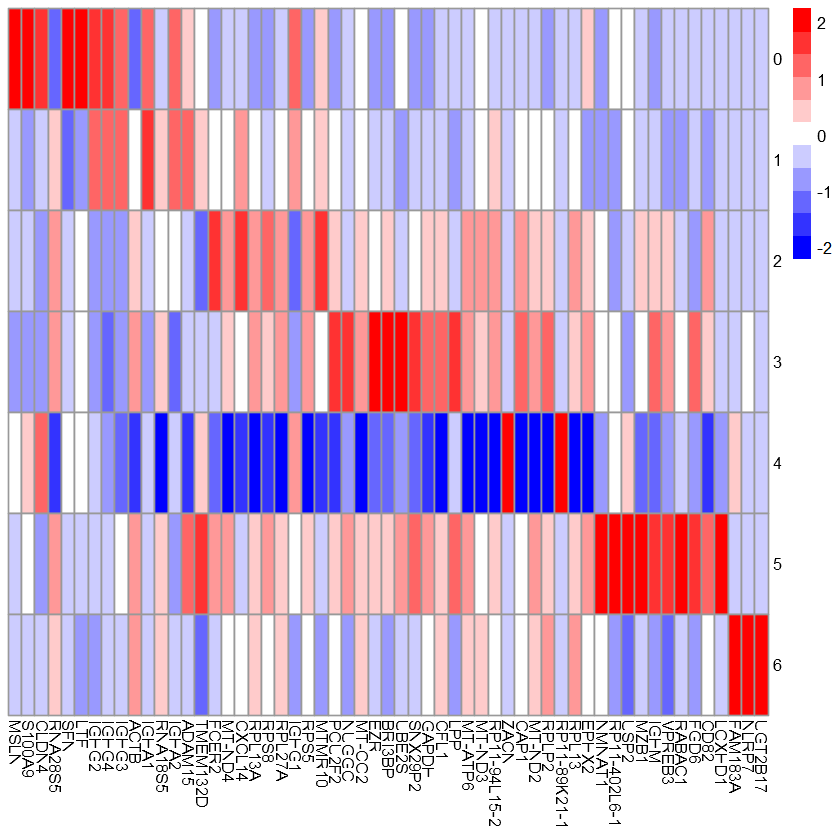

In [1]:
myplot <- function(
	a, ann, ann_color=NA, n.col=11, c_col=T, c_row=F, show_rownames=T, show_colnames=T, 
	breaks=seq(from=-max(abs(a)), to=max(abs(a)), len=n.col + 1), fontsize = 10
) {
	# print(a)
	pheatmap(
		a, color = colorRampPalette(c("blue", "white", "red"))(n.col), clustering_distance_rows = "correlation",  clustering_distance_cols = "correlation",  clustering_method = "complete",
		cluster_cols = c_col, cluster_rows = c_row, fontsize = fontsize
	)
}

top_gene_num = 10
dat_ = read.csv(paste0("./res/gene_dat_top=", top_gene_num, ".csv"), row.names=1)
dat_ = t(scale(t(dat_), center = TRUE, scale = TRUE))
dat_[dat_ > 4] = 4
dat_[dat_ < -4] = -4
colnames(dat_)=c("0", "1", "2", "3", "4", "5", "6")
s=rownames(dat_)
for(i in 1:length(s)){
  if(substr(s[i],1,15)=="mouse_rat_human"){
    s[i]=substr(s[i],17,nchar(s[i]))
  }
  if(substr(s[i],1,11)=="mouse_human"){
   s[i]=substr(s[i],13,nchar(s[i]))
  }
  if(substr(s[i],1,5)=="mouse"){
    s[i]=substr(s[i],7,nchar(s[i]))
  }
  if(substr(s[i],1,5)=="Mouse"){
    s[i]=substr(s[i],7,nchar(s[i]))
  }
  if(substr(s[i],1,5)=="Human"){
    s[i]=substr(s[i],7,nchar(s[i]))
  }
  if(substr(s[i],1,3)=="Rat"){
   s[i]=substr(s[i],5,nchar(s[i]))
  }  
}
rownames(dat_)=s
fontsize = 10
#pdf(paste0("./fig/fontsize=", fontsize, "_top=", top_gene_num, ".pdf"),width=11, height=3.7)
myplot(t(dat_), ann=NA, ann_color=NA, c_col=F, c_row=F, show_colnames=F, show_rownames=T, fontsize=fontsize)
dev.off()
tt=t(dat_)


## Perform Gene Set Enrichment Analysis
Use Cluster 1 as an example.

Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
"For some of the pathways the P-values were likely overestimated. For such pathways log2err is set to NA."


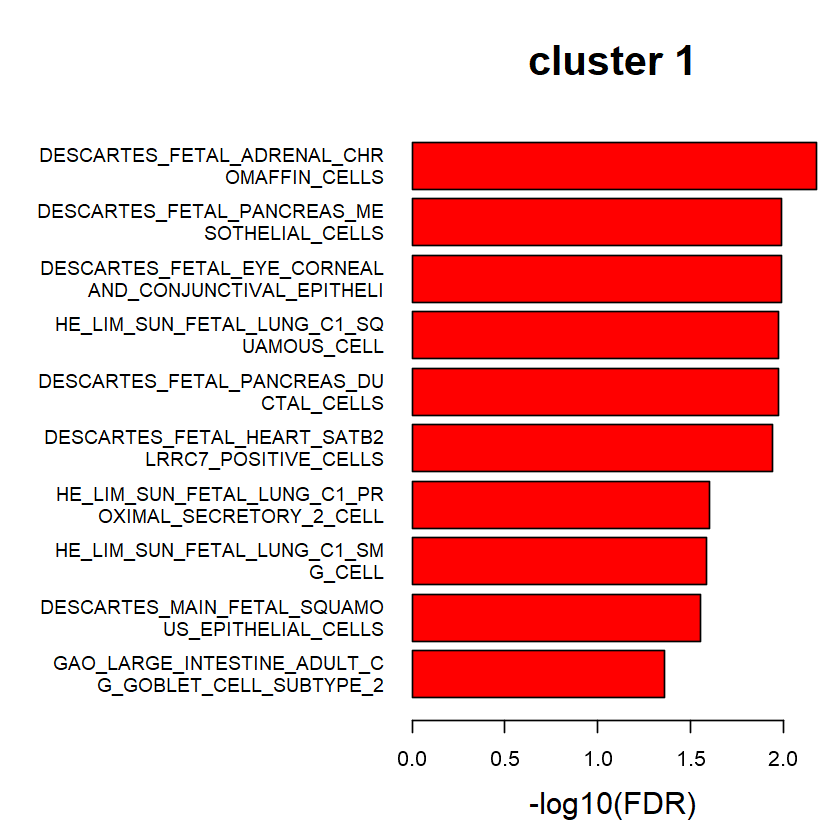

In [6]:
library(fgsea)
library(Seurat)
library (dplyr)
library(tibble)
library(GSA)
library(ggplot2)
library(stringr)

i = 1
colors <- c("red", "orange", "yellow", "green", "cyan", "blue", "purple", "deeppink")
gmt.file <- GSA::GSA.read.gmt("./data/c8.all.v2024.1.Hs.symbols.gmt")
de <- read.csv(paste0("Cluster_", as.character(i - 1), "_marker.csv"))

# sort genes according to logFC
colnames(de)[colnames(de) == "X"] <- "genes"
cluster0.genes<- de %>% arrange(desc(avg_log2FC)) %>% dplyr::select(genes,avg_log2FC)


ranks<- deframe(cluster0.genes)
pathways = gmt.file$genesets
names(pathways) = gmt.file$geneset.names

fgseaRes <- fgsea(pathways, ranks, minSize = 15, maxSize = 500)


half <- function(x) {
  n = 27
  string_length <- nchar(x)
  if (string_length < n + 5) {
    return(x)
  }
  if (string_length > 2 * n) {
    third_length = floor(string_length / 3)
    first_half <- substr(x, 1, n)
    if (substr(first_half, n, n) == "_") {
      first_half = substr(first_half, 1, n - 1)
    }
    second_half <- substr(x, n + 1, 2 * n - 1)
    if (substr(second_half, 1, 1) == "_") {
      second_half=substr(second_half, 2, n - 1)
    }
    if (substr(second_half, n - 1, n - 1) == "_") {
      second_half = substr(second_half, 1, n - 2)
    }
    return(paste(first_half, second_half, sep="\n"))
  }
  half_length <- floor(string_length / 2)
  
  first_half <- substr(x, 1, n)
  if(substr(first_half, n, n) ==" _") {
    first_half = substr(first_half, 1, n - 1)
  }

  second_half <- substr(x, n + 1, string_length)
  if(substr(second_half, 1, 1) == "_") {
    second_half=substr(second_half, 2, n - 1)
  }
  if(substr(second_half, n, n) == "_") {
    second_half = substr(second_half, 1, n - 2)
  }
  return(paste(first_half, second_half, sep="\n"))
}
fgsea=fgseaRes %>% as_tibble() %>% arrange(desc(padj)) %>% filter(padj < 0.05)
fgsea$leadingEdge<-NULL

Fgsea=fgseaRes %>% as_tibble() %>% arrange(desc(padj)) %>% filter(padj < 0.05) %>% head(n= 10)
name=Fgsea$pathway
name=sapply(name,function(x) half(x))
#pdf(paste0("./res/f", i, ".pdf"))#,width=11, height=7
par(mar=c(5, 17, 5, 1), fig=c(0, 1, 0, 1))
barplot(-log10(Fgsea$padj), names=name, col=colors[i], horiz = TRUE, las=1, xlab="-log10(FDR)", main=paste0("cluster ", as.character(i)), cex.names=0.92, cex.main=2, cex.lab=1.5)
#dev.off()
